In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
import pandas as pd
import pickle

In [4]:
import torch.utils.data as utils

In [5]:
import numpy as np

In [6]:
from sklearn.preprocessing import LabelEncoder


In [7]:
from sklearn.model_selection import train_test_split

### STEP 2: LOADING DATASET 

In [8]:
class FreeSoundDataset(Dataset):
    """ FreeSound dataset."""

    # Initialize your data, download, etc.
    def __init__(self, X, y):
        
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X)
        self.y_data = torch.from_numpy(y)

    def __getitem__(self, index):
        return (self.x_data[index], self.y_data[index])

    def __len__(self):
        return self.len

In [9]:
X = np.load('../data/processed/mel/train_curated_mel.npy')

In [10]:
X = X[:, : ,:128]

In [11]:
X.shape

(4970, 128, 128)

In [12]:
labels = pd.read_csv('../data/processed/train_curated.csv',sep=';')['labels']

In [13]:
labels = [l.split(',')[0] for l in labels]

In [14]:
le = LabelEncoder()
le.fit(labels)

LabelEncoder()

In [15]:
target = le.transform(labels) 

In [16]:
X_train, X_test, y_train, y_test=train_test_split(X, target, test_size=0.3, random_state=27, stratify=target)

In [17]:
print('X_train:', X_train.shape)

print('X_test:', X_test.shape)

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (3479, 128, 128)
X_test: (1491, 128, 128)
y_train: (3479,)
y_test: (1491,)


In [18]:
train_dataset = FreeSoundDataset(X_train, y_train)

In [19]:
test_dataset = FreeSoundDataset(X_test, y_test)

### STEP 2: MAKING DATASET ITERABLE

In [20]:
batch_size = 50
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

43

In [21]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size= batch_size, 
                                           shuffle=True)

In [22]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### STEP 3: CREATE MODEL CLASS

In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        # Convolution 2
        self.cnn2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2, stride=1, padding=1)
        self.relu2 = nn.ReLU()


        # Max pool 1
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        
        
        # Convolution 3
        self.cnn3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        # Convolution 4
        self.cnn4 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)


        # Convolution 5
        self.cnn5 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()

        # Convolution 4
        self.cnn6 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()

        # Max pool 3
        self.maxpool3 = nn.MaxPool1d(kernel_size=2)
     
              
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(128 * 16, 78) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x.float())
        out = self.relu1(out)
        
                
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max pool 1
        out = self.maxpool1(out)
        

        # Convolution 3
        out = self.cnn3(out)
        out = self.relu3(out)
        
                
        # Convolution 4 
        out = self.cnn4(out)
        out = self.relu4(out)

        # Max pool 2
        out = self.maxpool2(out)

        # Convolution 5
        out = self.cnn5(out)
        out = self.relu5(out)
        
                
        # Convolution 6
        out = self.cnn6(out)
        out = self.relu6(out)

        # Max pool 3
        out = self.maxpool3(out)
        
       
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

### STEP 4: INSTANTIATE MODEL CLASS

In [24]:
model = CNNModel()

In [25]:
#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

### STEP 5: INSTANTIATE LOSS CLASS

In [26]:
criterion = nn.CrossEntropyLoss()

### STEP 6: INSTANTIATE OPTIMIZER CLASS

In [27]:
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### STEP 7: TRAIN THE MODEL

In [41]:
niter = 0
lossv = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        #images = images.unsqueeze(1).type(torch.FloatTensor).cuda()
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        lossv.append(loss.data.tolist())
        
        # Updating parameters
        optimizer.step()
        
        niter += 1
        
        if niter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                else:
                    images = Variable(images)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(niter, loss.data, accuracy))

Iteration: 500. Loss: 0.06271558254957199. Accuracy: 26
Iteration: 1000. Loss: 0.006263910327106714. Accuracy: 26
Iteration: 1500. Loss: 0.0021832711063325405. Accuracy: 26
Iteration: 2000. Loss: 0.0010718422709032893. Accuracy: 26
Iteration: 2500. Loss: 0.0007109134458005428. Accuracy: 25
Iteration: 3000. Loss: 0.0006715559284202754. Accuracy: 25


In [28]:
niter = 0
lossv = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        #images = images.unsqueeze(1).type(torch.FloatTensor).cuda()
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        lossv.append(loss.data.tolist())
        
        # Updating parameters
        optimizer.step()

In [43]:
images, labels = next(iter(test_loader))  

In [44]:
if torch.cuda.is_available():
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
else:
    images = Variable(images)
    labels = Variable(labels)

In [45]:
# Forward pass only to get logits/output
outputs = model(images)


In [46]:
outputs.shape

torch.Size([50, 78])

In [47]:
# Get predictions from the maximum value
nose, predicted = torch.max(outputs.data, 1)

In [48]:
predicted

tensor([52, 38, 30, 30, 20,  2, 65, 67, 53, 31, 66, 46, 60,  9, 74,  4, 46,  3,
         9, 21, 21, 39, 11, 29, 26,  4, 52, 72, 69, 71, 34, 15, 40,  6, 11, 21,
        70, 77, 37, 43, 37,  6, 21, 40, 74,  3,  9, 34, 52, 48],
       device='cuda:0')

In [49]:
labels

tensor([31, 38, 11,  9, 49, 74, 70, 75,  4, 44, 11,  4, 76,  9,  8, 18, 50,  3,
         9, 21, 21, 49, 24, 29, 26, 46,  2, 74, 45, 65, 74, 15,  7,  6, 73, 53,
        10, 33, 37, 43, 37,  6, 67,  7, 31,  3,  9, 34, 12, 10],
       device='cuda:0')

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
import itertools

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    #print(cm)
    #print ()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
cnf_matrix = confusion_matrix(labels.cpu(), predicted.cpu())


Confusion matrix, without normalization


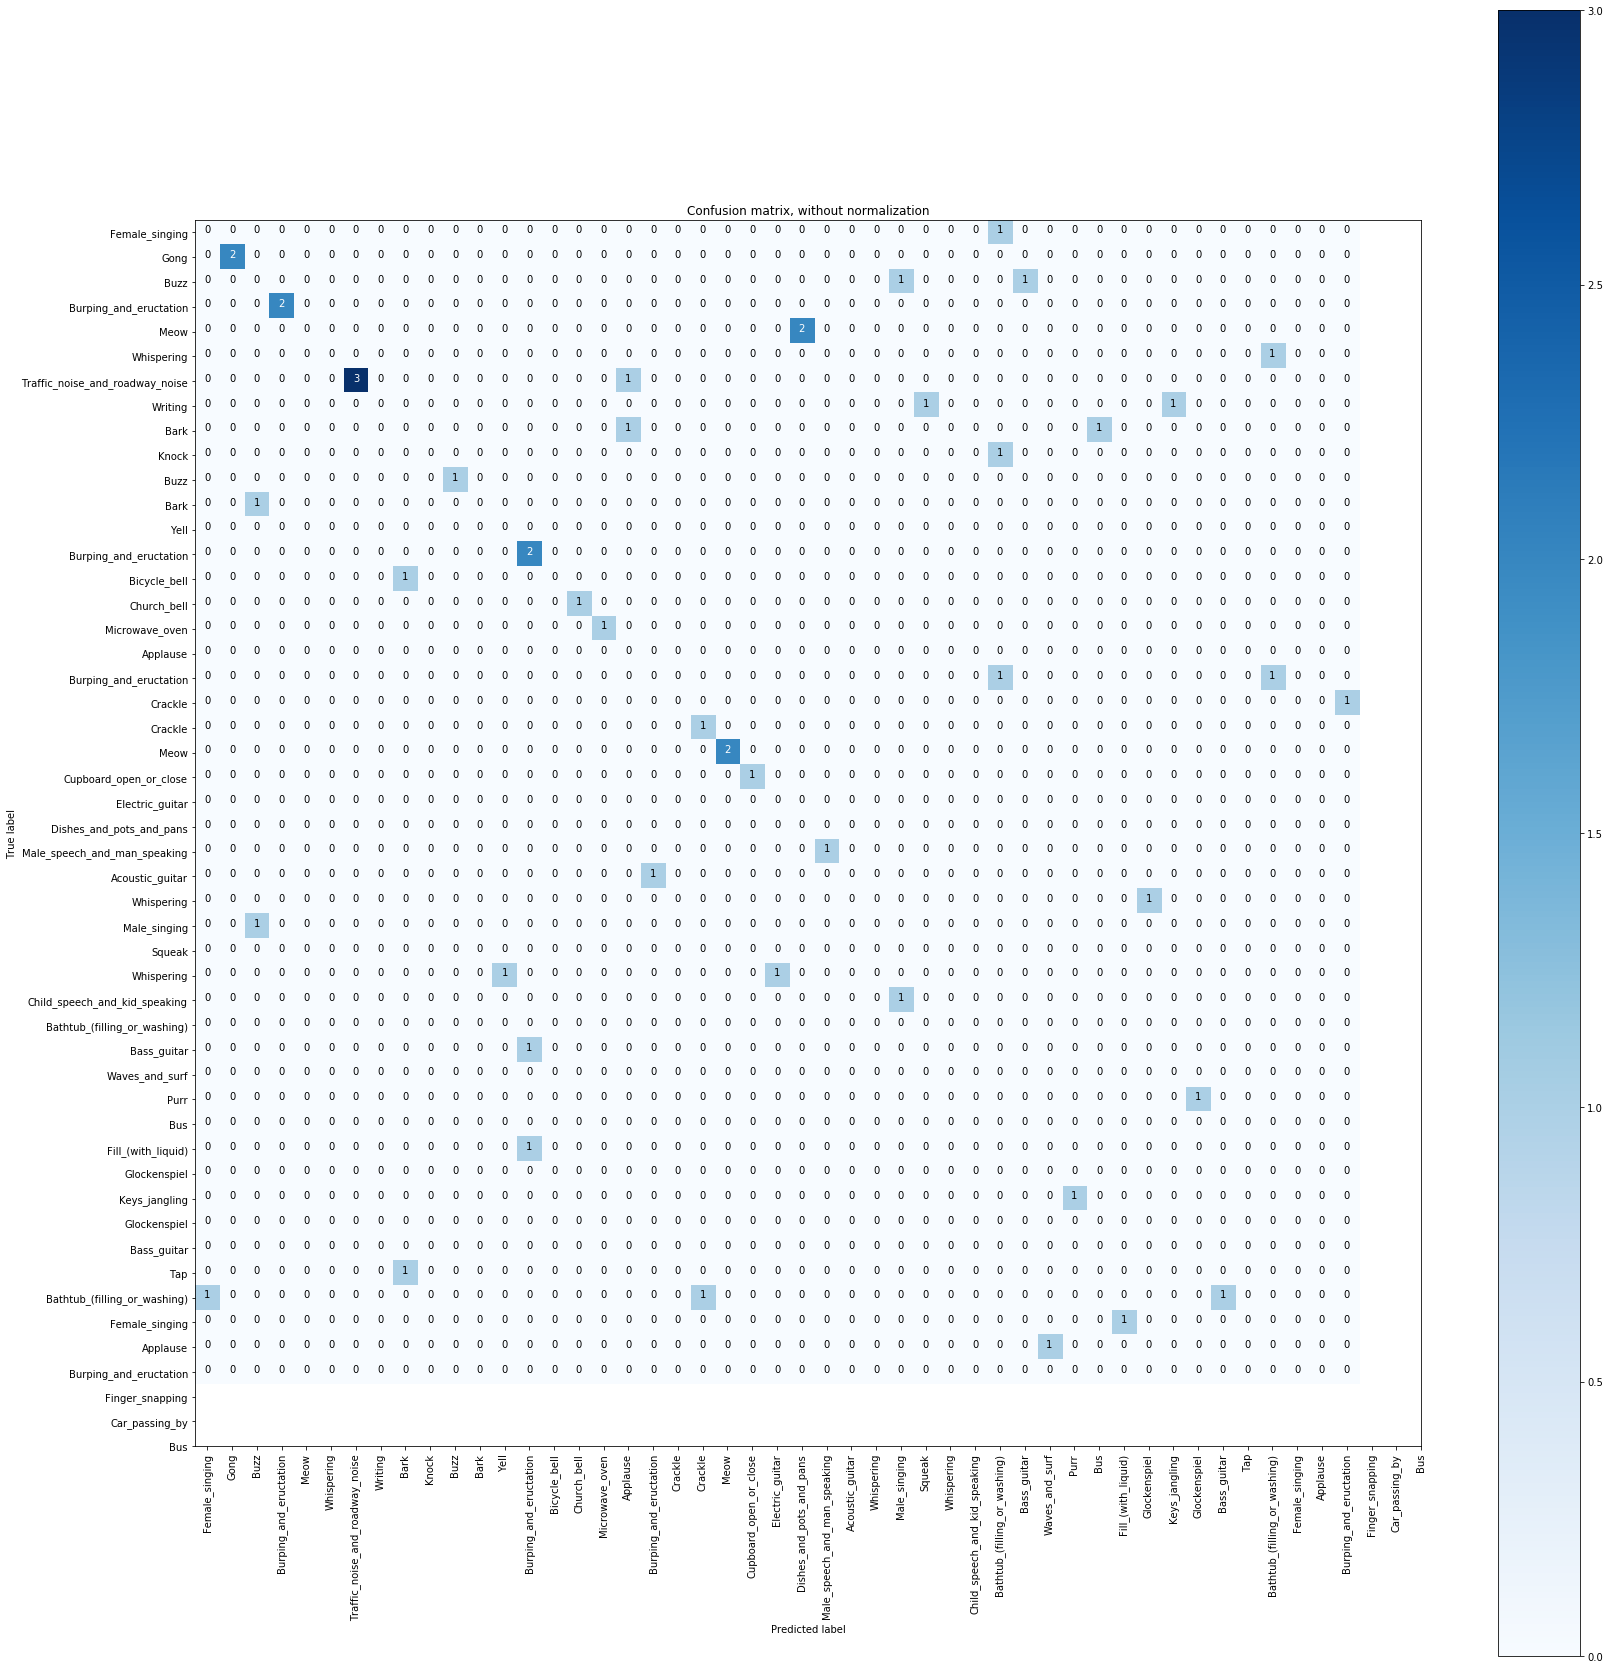

In [52]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(24, 24))
plot_confusion_matrix(cnf_matrix, classes=le.inverse_transform(labels.cpu()),
                      title='Confusion matrix, without normalization')

In [45]:
cnf_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [45]:
import matplotlib.pyplot as plt

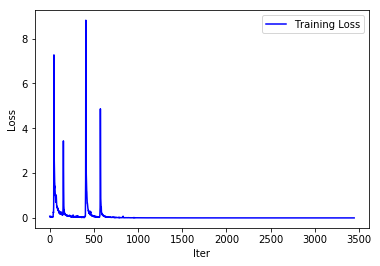

In [46]:
# Visualize loss history
plt.plot(lossv, 'b-')
plt.legend(['Training Loss'])
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show();